<a href="https://colab.research.google.com/github/rlaaudrb1104/Ai/blob/KMG/feature_engineering3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install transformers[torch]
!pip install accelerate

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00


In [7]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, RobertaConfig, RobertaModel, RobertaPreTrainedModel, Trainer, TrainingArguments
import torch.nn as nn
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

# CUDA 디버깅 설정
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# CSV 파일 로드
df = pd.read_csv("/content/drive/MyDrive/Dataset/MSR+julite+Div_final_train(feature).csv")


# 코드 컬럼, 라벨 컬럼, 피쳐 컬럼 분리
code_texts = df['code'].tolist()
labels = df['labels'].tolist()

# 라벨이 0부터 9까지 있는지 확인
assert all(0 <= label < 10 for label in labels), "라벨이 0부터 9까지의 범위에 있어야 합니다."

features = df.drop(columns=['code', 'labels', 'lang','CWE ID']).values.astype(np.float32)  # float 타입으로 변환

# 피처 크기 확인 및 설정
feature_size = features.shape[1]
print(f"Feature size: {feature_size}")

# 토크나이저 초기화
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

# 코드를 토큰화
encodings = tokenizer(code_texts, padding=True, truncation=True, return_tensors='pt')

# 데이터셋 클래스 정의
class CodeDataset(Dataset):
    def __init__(self, encodings, labels, features):
        self.encodings = encodings
        self.labels = labels
        self.features = features

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        item['features'] = torch.tensor(self.features[idx], dtype=torch.float)
        return item

# 데이터셋 생성 및 분리
train_texts, val_texts, train_labels, val_labels, train_features, val_features = train_test_split(
    code_texts, labels, features, test_size=0.2, random_state=42)

train_encodings = tokenizer(train_texts, padding=True, truncation=True, return_tensors='pt')
val_encodings = tokenizer(val_texts, padding=True, truncation=True, return_tensors='pt')

train_dataset = CodeDataset(train_encodings, train_labels, train_features)
val_dataset = CodeDataset(val_encodings, val_labels, val_features)

# 모델 정의
class CodeBERTConfig(RobertaConfig):
    model_type = "codebert"

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.max_position_embeddings = 514  # 사전 학습된 모델과 일치
        self.type_vocab_size = 1  # 사전 학습된 모델과 일치
        self.output_attentions = True  # 어텐션 가중치 반환 설정

class CodeBERTForVulnerabilityDetectionWithFeatures(RobertaPreTrainedModel):
    config_class = CodeBERTConfig

    def __init__(self, config, feature_size):
        super().__init__(config)
        self.num_labels = 10  # 0부터 9까지의 10개 클래스
        self.feature_size = feature_size
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.feature_dense = nn.Linear(self.feature_size, config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size * 2, self.num_labels)  # Concatenate RoBERTa output with features
        self.init_weights()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, features=None, labels=None, return_attentions=False):
        if features is None:
            raise ValueError("features를 제공해야 합니다.")

        outputs = self.roberta(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, output_attentions=return_attentions)
        sequence_output = outputs[0]

        pooled_output = sequence_output[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        feature_output = self.feature_dense(features)
        feature_output = self.dropout(feature_output)

        combined_output = torch.cat((pooled_output, feature_output), dim=1)
        logits = self.classifier(combined_output)

        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            if return_attentions:
                attentions = outputs.attentions
                return {"loss": loss, "logits": logits, "attentions": attentions}
            return {"loss": loss, "logits": logits}

        if return_attentions:
            attentions = outputs.attentions
            return {"logits": logits, "attentions": attentions}

        return {"logits": logits}


# 커스텀 메트릭스 함수 정의
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # 각 클래스에 대한 F1 스코어 계산
    f1_per_class = f1_score(labels, predictions, average=None, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    # 가중 평균, 매크로 평균, 마이크로 평균 F1 스코어 계산
    f1_weighted = f1_score(labels, predictions, average='weighted')
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_micro = f1_score(labels, predictions, average='micro')
    recall_weighted = recall_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)

    # 결과를 딕셔너리 형태로 저장
    metrics = {
        'accuracy': accuracy,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
    }

    # 클래스별 F1 스코어를 딕셔너리에 추가
    for i, f1 in enumerate(f1_per_class):
        metrics[f'f1_class_{i}'] = f1

    return metrics

# 모델 초기화
config = CodeBERTConfig()
model = CodeBERTForVulnerabilityDetectionWithFeatures(config, feature_size=feature_size)

# 사전 학습된 가중치 로드
pretrained_model = RobertaModel.from_pretrained("microsoft/codebert-base")
model.roberta.load_state_dict(pretrained_model.state_dict(), strict=False)

# 모델을 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# TrainingArguments 설정
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    evaluation_strategy="steps",     # 평가 전략을 "steps"로 설정
    eval_steps=100,                   # 100 스텝마다 평가
    fp16=True                        # 16비트 연산 사용
)

# 데이터셋을 위한 데이터 콜레이터 정의
def data_collator(features):
    input_ids = torch.stack([f['input_ids'] for f in features])
    attention_mask = torch.stack([f['attention_mask'] for f in features])
    labels = torch.stack([f['labels'] for f in features])
    additional_features = torch.stack([f['features'] for f in features])
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'features': additional_features,
        'labels': labels
    }

# Trainer 초기화
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    data_collator=data_collator,         # data collator for batching
    compute_metrics=compute_metrics      # 커스텀 메트릭스 함수
)
import torch
torch.cuda.empty_cache()
# 모델 훈련
trainer.train()

# 모델 평가
results = trainer.evaluate()
print(results)

Feature size: 101


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8,F1 Class 9
100,No log,2.141181,0.267583,0.267583,0.166206,0.112793,0.267583,0.437569,0.325542,0.000000,0.010390,0.000000,0.354430,0.000000,0.000000,0.000000,0.000000
200,No log,1.940622,0.321292,0.321292,0.258541,0.208441,0.321292,0.461380,0.368125,0.243952,0.041775,0.020478,0.833992,0.069869,0.044843,0.000000,0.000000
300,No log,1.893310,0.355179,0.355179,0.298502,0.249263,0.355179,0.484083,0.359331,0.135531,0.292845,0.177285,0.836653,0.206897,0.000000,0.000000,0.000000
400,No log,1.841014,0.364770,0.364770,0.301984,0.245088,0.364770,0.605672,0.361121,0.011019,0.202410,0.234987,0.836653,0.010204,0.188811,0.000000,0.000000
500,2.050500,1.729492,0.383312,0.383312,0.378447,0.332408,0.383312,0.627826,0.341506,0.227886,0.327345,0.363636,0.830040,0.213523,0.301418,0.019048,0.071856
600,2.050500,1.617570,0.438939,0.438939,0.401703,0.342618,0.438939,0.627609,0.408451,0.331210,0.383513,0.374723,0.836653,0.020619,0.297118,0.109244,0.037037
700,2.050500,1.497203,0.487852,0.487852,0.456346,0.404500,0.487852,0.671744,0.449424,0.405136,0.482759,0.384810,0.859885,0.083721,0.301775,0.064516,0.341232
800,2.050500,1.444111,0.521100,0.521100,0.491601,0.446006,0.521100,0.682618,0.491420,0.436310,0.468852,0.498294,0.856089,0.206897,0.354767,0.069652,0.395161
900,2.050500,1.439367,0.511509,0.511509,0.489190,0.440941,0.511509,0.705570,0.476244,0.444776,0.478142,0.433915,0.858736,0.307692,0.345455,0.010256,0.348624
1000,1.563800,1.369066,0.543798,0.543798,0.518976,0.470422,0.543798,0.739233,0.524258,0.432859,0.504146,0.498507,0.853974,0.362416,0.357542,0.051282,0.380000


{'eval_loss': 1.224994421005249, 'eval_accuracy': 0.5997442455242967, 'eval_recall_weighted': 0.5997442455242967, 'eval_f1_weighted': 0.586443208053253, 'eval_f1_macro': 0.5487418864668482, 'eval_f1_micro': 0.5997442455242967, 'eval_f1_class_0': 0.7808764940239044, 'eval_f1_class_1': 0.5679574791192104, 'eval_f1_class_2': 0.5343915343915343, 'eval_f1_class_3': 0.5585585585585586, 'eval_f1_class_4': 0.541501976284585, 'eval_f1_class_5': 0.862453531598513, 'eval_f1_class_6': 0.4943181818181818, 'eval_f1_class_7': 0.43274853801169594, 'eval_f1_class_8': 0.2801556420233463, 'eval_f1_class_9': 0.4344569288389513, 'eval_runtime': 27.9363, 'eval_samples_per_second': 111.969, 'eval_steps_per_second': 7.016, 'epoch': 1.0}


In [8]:
# 평가 시 어텐션 반환
eval_dataloader = trainer.get_eval_dataloader()
for batch in eval_dataloader:
    inputs = {key: val.to(trainer.args.device) for key, val in batch.items()}
    with torch.no_grad():
        outputs = model(**inputs, return_attentions=True)
    attentions = outputs['attentions']

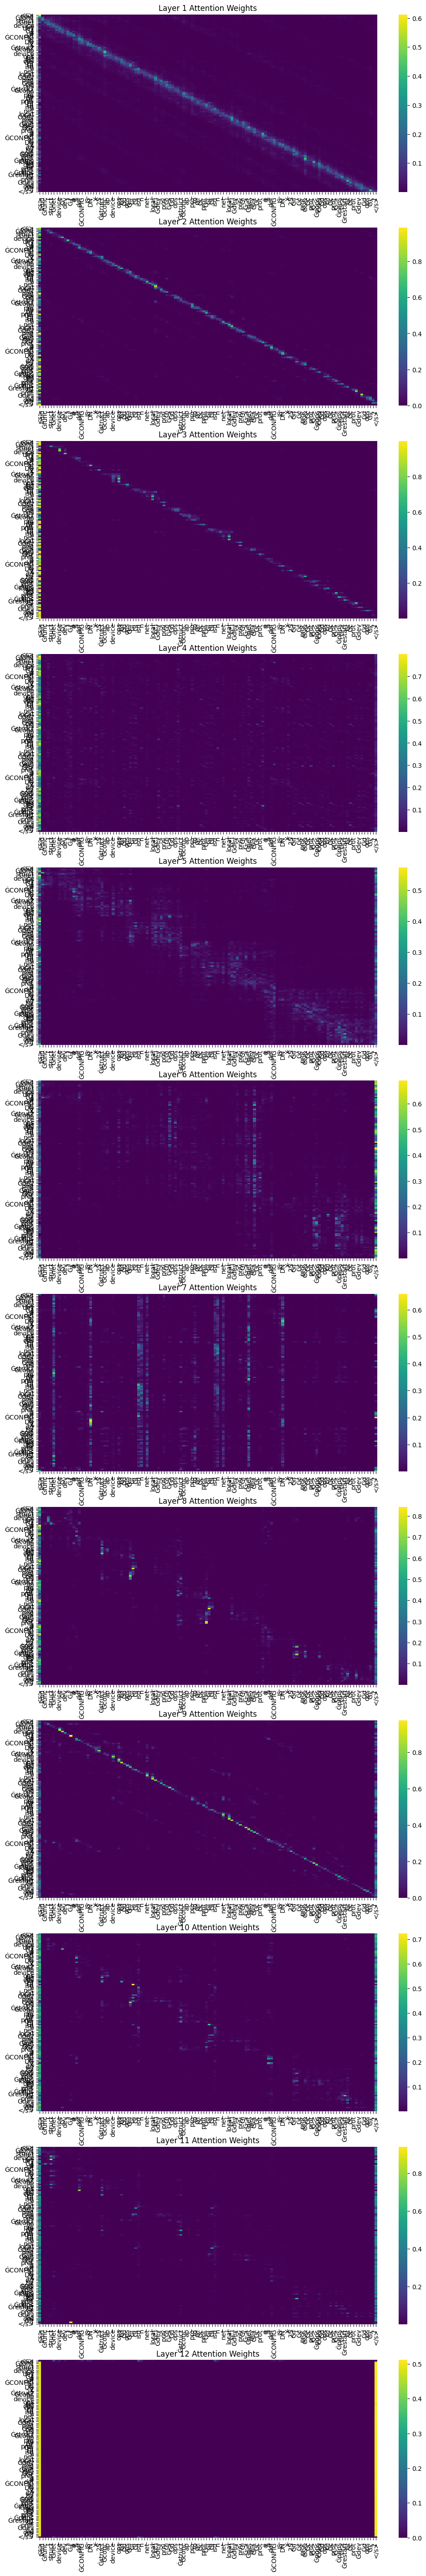

In [15]:
# Attention Weights 추출 및 시각화 함수 정의
def visualize_attention(inputs, attentions):
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    fig, axs = plt.subplots(len(attentions), 1, figsize=(12, 6 * len(attentions)))
    if len(attentions) == 1:
        axs = [axs]

    for i, attention in enumerate(attentions):
        attention = attention[0][0].detach().cpu().numpy()
        sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, ax=axs[i], cmap="viridis")
        axs[i].set_title(f'Layer {i + 1} Attention Weights')
    plt.show()

# 예제 코드에 대한 어텐션 가중치 시각화
example_code = df['code'].iloc[20]
example_features = features[0]  # 예제 코드에 대한 피처

inputs = tokenizer(example_code, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
inputs['features'] = torch.tensor(example_features, dtype=torch.float).unsqueeze(0).to(device)

# 모델의 출력을 얻기 위해 평가 모드로 전환
model.eval()
with torch.no_grad():
    outputs = model(**inputs, return_attentions=True)

# 어텐션 가중치 추출
attentions = outputs['attentions']

# 시각화 함수 호출
visualize_attention(inputs, attentions)

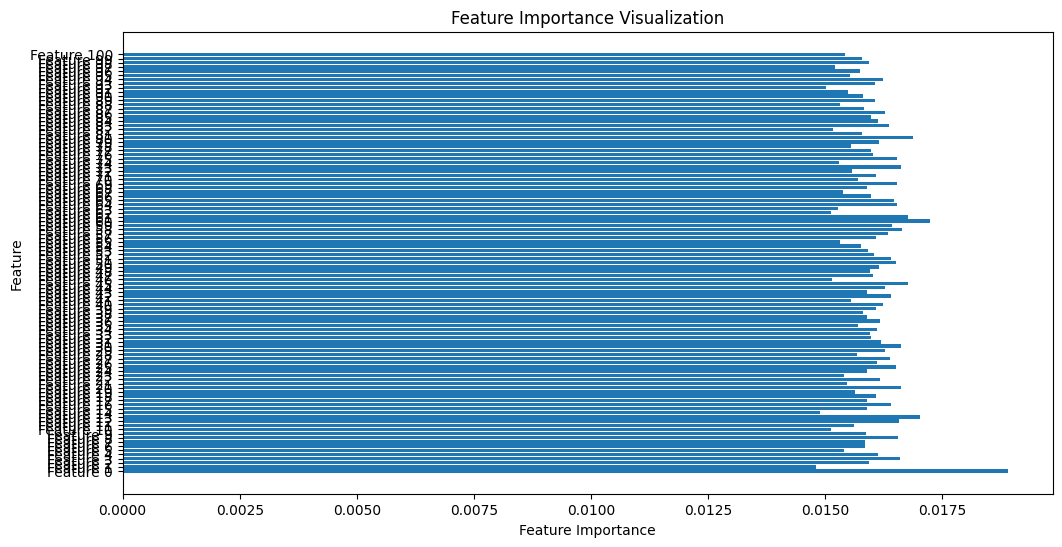

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def visualize_feature_importance(model, feature_names):
    # 모델의 feature dense 레이어의 가중치 추출
    feature_weights = model.feature_dense.weight.detach().cpu().numpy()

    # 가중치의 절대값을 사용하여 중요도 계산
    feature_importance = np.abs(feature_weights).mean(axis=0)

    # 피처 중요도 시각화
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(feature_importance)), feature_importance, align='center')
    plt.yticks(range(len(feature_importance)), feature_names)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance Visualization')
    plt.show()

# 예제 피처 이름
feature_names = [f'Feature {i}' for i in range(feature_size)]

# 피처 중요도 시각화 함수 호출
visualize_feature_importance(model, feature_names)

In [18]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/MSR+julite+Div_final_train(feature).csv")

In [19]:
df.columns

Index(['CWE ID', 'vul', 'lang', 'code', 'labels', 'chmod()', 'assert()',
       'atoi()', 'atof()', 'calloc()',
       ...
       'array_index_vulnerability', 'int', 'short', 'long', 'long long',
       'unsigned int', 'unsigned short', 'unsigned long', 'unsigned long long',
       'line_count'],
      dtype='object', length=105)

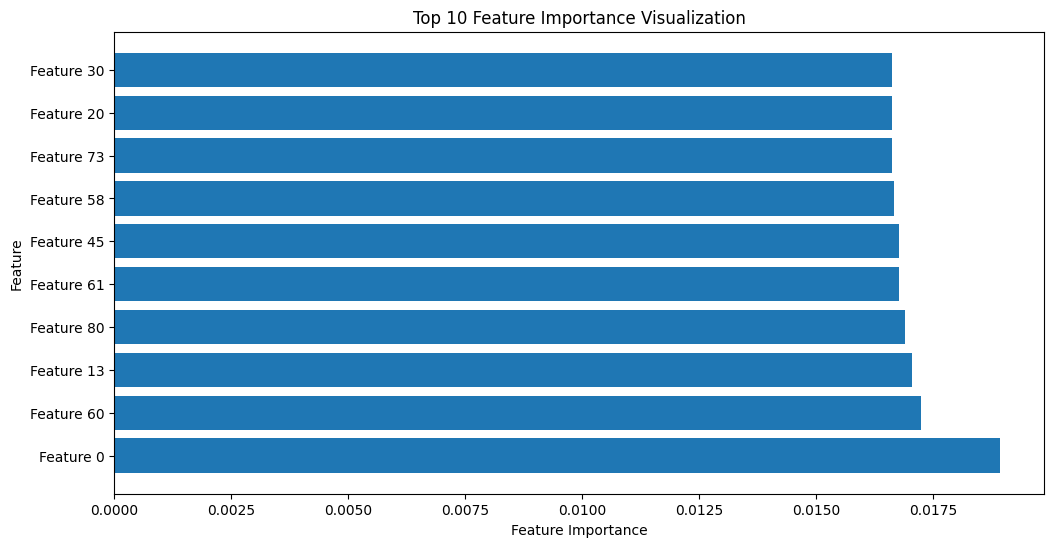

In [16]:
def visualize_top_features(model, feature_names, top_n=10):
    # 모델의 feature dense 레이어의 가중치 추출
    feature_weights = model.feature_dense.weight.detach().cpu().numpy()

    # 가중치의 절대값을 사용하여 중요도 계산
    feature_importance = np.abs(feature_weights).mean(axis=0)

    # 상위 top_n 피처의 인덱스와 중요도 추출
    top_indices = np.argsort(feature_importance)[-top_n:][::-1]
    top_importance = feature_importance[top_indices]
    top_features = [feature_names[i] for i in top_indices]

    # 피처 중요도 시각화
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(top_importance)), top_importance, align='center')
    plt.yticks(range(len(top_importance)), top_features)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Feature Importance Visualization')
    plt.show()

# 예제 피처 이름
feature_names = [f'Feature {i}' for i in range(feature_size)]

# 상위 10개의 피처 중요도 시각화 함수 호출
visualize_top_features(model, feature_names, top_n=10)

In [ ]:
df['code'].iloc[0]

'void func(struct net_device *d) { isdn_net_local *lp = (isdn_net_local *) d->priv; isdn_ctrl cmd;#ifdef CONFIG_ISDN_X25 struct concap_proto *cprot = lp->netdev->cprot; struct concap_proto_ops *pops = cprot ? cprot->pops : NULL; if (lp->flags & ISDN_NET_CONNECTED) { if (lp->slave != NULL) { isdn_net_local *slp = (isdn_net_local *)lp->slave->priv; if (slp->flags & ISDN_NET_CONNECTED) { printk(KERN_INFO "isdn_net: hang up slave %s before %s\\n", lp->slave->name, d->name); isdn_net_hangup(lp->slave); } } printk(KERN_INFO "isdn_net: local hangup %s\\n", d->name);#ifdef CONFIG_ISDN_PPP if (lp->p_encap == ISDN_NET_ENCAP_SYNCPPP) isdn_ppp_free(lp); isdn_net_lp_disconnected(lp);#ifdef CONFIG_ISDN_X25 if( pops && pops -> disconn_ind ) pops -> disconn_ind(cprot); cmd.driver = lp->isdn_device; cmd.command = ISDN_CMD_HANGUP; cmd.arg = lp->isdn_channel; isdn_command(&cmd); printk(KERN_INFO "%s: Chargesum is %d\\n", d->name, lp->charge); isdn_all_eaz(lp->isdn_device, lp->isdn_channel); } isdn_net_un